# Introduction
This notebook analyzes the effect of adjusting loss functions according to the business objectives in training of a neural network. The data used in this notebook is from the Udemy course [Deep Learning A-Z™: Hands-On Artificial Neural Networks](https://www.udemy.com/deeplearning/learn/v4/overview). The data is provided for the first assignment of the course and it relates to predicting a hypothetical bank's customer churn using deep neural networks.

In this classification problem, accuracy of prediction is not necessarily what we care about the most. Misclassifying a customer who will leave the bank is worse than misclassifying a customer who will stay. This notebook is an example of how we can apply the business objective directly into the training of the model and attain superior results.

# Data Preprocessing

In [268]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import keras.backend as K
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

In [269]:
# Importing the dataset
dataset = pd.read_csv('Churn_Modelling.csv')
dataset.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [342]:
print(dataset.shape)

(10000, 14)


In [308]:
# Getting the relevant columns
X = dataset.iloc[:, 3:13].values
y = dataset.iloc[:, 13].values

In [309]:
# Encoding categorical data
labelencoder_X_1 = LabelEncoder()
X[:, 1] = labelencoder_X_1.fit_transform(X[:, 1])
labelencoder_X_2 = LabelEncoder()
X[:, 2] = labelencoder_X_2.fit_transform(X[:, 2])
# Take care of the non-cardinality of the categorical variables
onehotencoder = OneHotEncoder(categorical_features = [1])
X = onehotencoder.fit_transform(X).toarray()
#Removing the first column to not fall into the "dummy variable trap"
X = X[:, 1:]

In [286]:
# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [291]:
# Feature Scaling
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
print('First row of train set:')
print((X_train[0,:]))

First row of train set:
[-0.5698444   1.74309049  0.1692298  -1.09168714 -0.46460796  0.00666099
 -1.21571749  0.8095029   0.64259497 -1.03227043  1.10643166]


# Train, test and analyze adjusted loss function
Assuming that error in prediction of the exit class (customers who will leave the bank), is 5 times as important of the stay class, I define the following weights for how elements of the confusion metrics impact the value of the business objective.  

In [310]:
class_exit_weight = 5

reward_tp = class_exit_weight
reward_tn = 1
reward_fp = -1
reward_fn = -class_exit_weight

In [ ]:
# Set up an empty dataframe to save relevant stats
stats = pd.DataFrame(columns=['tn', 'fp', 'fn', 'tp', 'p_0', 'p_1', 'c_0', 'c_1', 'Business', 'accuracy'])
# p_0: number of predictions in the stay class
# p_1: number of predictions in the leave class
# c_0: number of customers in the stay class
# c_1: number of customers in the leave class
# Business: value of the business objective
# accuracy: prediction accuracy

In [ ]:
# Test loss function weights ranging from 1 to 20. 
weights = np.arange(1,21)

for weight in weights:
    class_weight = {0 : 1., 1: weight}

    # Initialising the ANN
    classifier = Sequential()

    # Adding the input layer and the first hidden layer
    classifier.add(Dense(units = 6, kernel_initializer = 'uniform', activation = 'relu', input_dim = 11))
    classifier.add(Dense(units = 6, kernel_initializer = 'uniform', activation = 'relu'))
    classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
    classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy')
    # Fit the neural net
    classifier.fit(X_train, y_train, batch_size = 256, epochs = 10, class_weight = class_weight, verbose = 0 )

    # Predicting the Test set results
    y_pred = classifier.predict(X_test)
    y_pred = (y_pred > 0.5)

    # Making the Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    # Save the stats
    stats.loc[len(stats)] = [cm[0,0], cm[0,1], cm[1,0], cm[1,1], 
                             cm[0,0] + cm[1,0], cm[1,1] + cm[0,1], 
                             cm[0,0]+cm[0,1], cm[1,0]+cm[1,1],
                            reward_tp*cm[1,1] + reward_tn*cm[0,0] + reward_fp*cm[0,1] + reward_fn*cm[1,0],
                            (cm[0,0] + cm[1,1])/cm.sum()]

# Plotting and Analysis
Now, let's see how the results change depending on how heavily the errors of class 1 are weighted in the loss function.

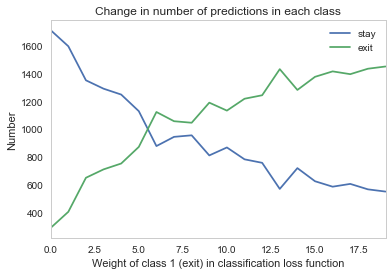

In [347]:
stats[['p_0','p_1']].plot()
plt.title('Change in number of predictions in each class')
plt.legend(['stay','exit'])
plt.xlabel('Weight of class 1 (exit) in classification loss function')
plt.ylabel('Number')
plt.show()

Plot above shows that the more we the loss function weight, the more the number of customers predicted as leaving. The rate of this increase is higher in the beginning.

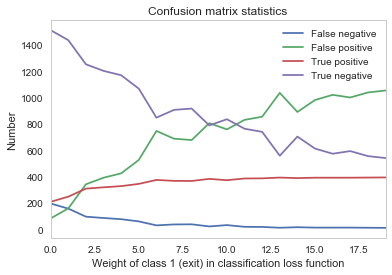

In [348]:
stats[['fn', 'fp','tp','tn']].plot()
plt.title('Confusion matrix statistics')
plt.legend(['False negative','False positive', 'True positive', 'True negative'])
plt.xlabel('Weight of class 1 (exit) in classification loss function')
plt.ylabel('Number')
plt.show()

Plot above shows how False negative, False positive, True positive and True negative values change as a function of classification loss weight. The trends follow the expectation.

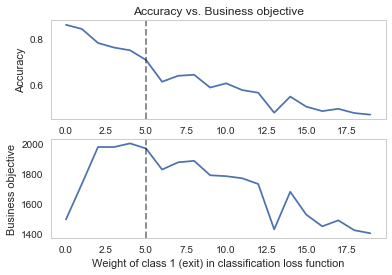

In [349]:
plt.figure(1)
plt.subplot(211)
plt.title('Accuracy vs. Business objective')
plt.plot(stats[['accuracy']])
plt.ylabel('Accuracy')
plt.axvline(x=reward_1, color='k', linestyle='--', alpha=0.5)
plt.subplot(212)
plt.plot(stats[['Business']])
plt.ylabel('Business objective')
plt.xlabel('Weight of class 1 (exit) in classification loss function')
plt.axvline(x=reward_1, color='k', linestyle='--', alpha=0.5)
plt.show()

Plot above shows that accuracy decreases as the weight increases. On the other hand, the value of the business objectives obtained from the predictions of the neural network peaks around 5 which is the value of the weight in the original business objective! Nice!

# Validating the adjusted loss function effect
Now, let's examine whether the results obtained above is random or not. Below, we experiment business objective weights ranging from 1 to 15 (previously I only experimented with the value of 5). We want to see if the same trend is repeated i.e. whether the optimal value of the weight of the loss function is around the weight of the business objective.

Below, I iterate over different weights of the business objective. First, I write a function that calculates the value of the business objective obtained by the neural network given the business objective weight.

In [88]:
def weight_analysis(w_1):
    reward_tp = w_1
    reward_tn = 1
    reward_fp = -1
    reward_fn = -w_1
    business_objective_results = []
    weights = np.arange(1,21)
    for weight in weights:
        class_weight = {0 : 1., 1: weight}

        classifier = Sequential()
        classifier.add(Dense(units = 6, kernel_initializer = 'uniform', activation = 'relu', input_dim = 11))
        classifier.add(Dense(units = 6, kernel_initializer = 'uniform', activation = 'relu'))
        classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
        classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
        classifier.fit(X_train, y_train, batch_size = 256, epochs = 11, class_weight = class_weight, verbose = 0 )

        y_pred = classifier.predict(X_test)
        y_pred = (y_pred > 0.5)

        cm = confusion_matrix(y_test, y_pred)
        business_objective_results.append(reward_tp*cm[1,1] + reward_tn*cm[0,0] + reward_fp*cm[0,1] + reward_fn*cm[1,0])
                                   
    return business_objective_results

In the next cell, I iterate over function above. This cell takes a long time to run. I have commented the code out to prevent an accidental run. If you want to run it, first do it on 1 or two iterations and estimate the run time.

In [ ]:
#opt_weight = []
#business_weights = np.arange(1,15)
#for w_1 in business_weights:
#    temp = weight_analysis(w_1)
#    opt_weight.append(temp)

In [207]:
# Convert and transpose 2d list to dataframe 
business_objective_results = pd.DataFrame(list(map(list, zip(*opt_weight))))

Now, Let's see business objective predictions as a function of the business objective weight and the classification loss weight. If the maximum objective is achieved when the classification weight is around the actual business objective weight, we are on the right track!

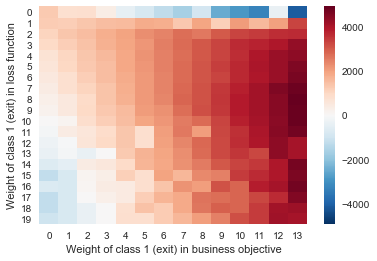

In [350]:
sns.heatmap(business_objective_results, annot=False)
plt.ylabel('Weight of class 1 (exit) in loss function')
plt.xlabel('Weight of class 1 (exit) in business objective')

plt.show()

Plot above shows that generally speaking, the neural net business objective is maximized when the loss function weight is around the original business objetive weight. Seems like the results we saw previously was not random! Let's do more analysis and makes this more clear.

In cell below, I extract the value of the business objective produced by the neural net for cases when the classification loss function is not adjusted as a well as for when it is adjusted with weights exactly equal to the business objective weights originally set.

In [ ]:
# Get the value of the business objective where the loss function weight is equal to the business objective weight
business_objective_results_adjusted_loss = []
for ind in range(business_objective_results.shape[1]):
    business_objective_results_adjusted_loss.append(business_objective_results[ind][ind])    
business_objective_results_adjusted_loss = pd.Series(business_objective_results_adjusted_loss)
# Get the value of the business objective where the loss function weight is not weighted.
business_objective_results_unadjusted_loss = business_objective_results[0][0:business_objective_results.shape[1]]

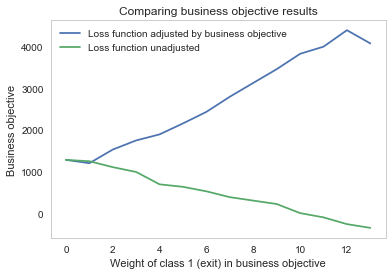

In [351]:
plt.plot(business_objective_results_adjusted_loss)
plt.plot(business_objective_results_unadjusted_loss)
plt.title('Comparing business objective results')
plt.legend(['Loss function adjusted by business objective', 'Loss function unadjusted'], frameon=False)
plt.xlabel('Weight of class 1 (exit) in business objective')
plt.ylabel('Business objective')

plt.show()

The plot above shows that business objective predictions increase if we incorporate the business objective into the loss function. It decreases if we don't.

We iterated over a range of weights for the adjusted loss function. We know from plot above that when we adjust the loss function by the weight exactly equal to the business objective weight, we get better results compared to the unadjusted loss. But how good are the loss function weights which are exactly equal to the business objective weights? Are there other weights in the range we experimented which produce higher business objective values? If so, how far is the objective value produced by the loss function weight exactly equal to the business objective weight from the maximum predicted objective value?

In the next cell, I investigate that.

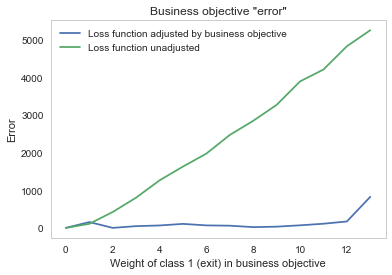

In [346]:
max_objectives = business_objective_results.max()
distance_from_max_adjusted_loss = (business_objective_results_adjusted_loss - max_objectives).abs()
distance_from_max_unadjusted_loss = (business_objective_results_unadjusted_loss - max_objectives).abs()

plt.plot(distance_from_max_adjusted_loss)
plt.plot(distance_from_max_unadjusted_loss)
plt.xlabel('Weight of class 1 (exit) in business objective')
plt.ylabel('Error')
plt.title('Business objective "error"')
plt.legend(['Loss function adjusted by business objective', 'Loss function unadjusted'])

plt.show()

The "error" in the plot above is defined as how far the value of the business objective is from the "optimal" value in the experiment. The "optimal" value is the maximum value of the business objective predicted by the neural net given the vectors of weights to the loss function weight.

The error in the unadjusted loss function increases as the business objective weight increases. However, it is relatively constant when the loss function is adjusted. The fact that the error of the business objective achieved by the adjusted loss function is so close to zero suggests that the loss function weight exactly equal to the business objective weight is always near the maximum and therefore a safe and good choice. 

# Conclusion
Optimze for what you care!